# **Data Diri**
Nama : Isaac Dwadattusyah Haikal Azziz

Kota Pasuruan, Jawa Timur

Proyek Dicoding Klasifikasi Batu Gunting Kertas (Pembaruan Sertifikat)

# **Dependencies & Preprocessing**

In [1]:
#Install Dependencies not in colab
!pip install wget
!pip install split-folders
!pip install split-folders tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=c6cce760a55159d3563e57c804ea429fc3986dcbd5464f612b55bba2be56b897
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#Dependencies
import zipfile
import os
import time
import wget
import splitfolders

import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras


from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping

from google.colab import files
%matplotlib inline

In [3]:
#Download File
url = 'https://github.com/dicodingacademy/assets/releases/download/release/rockpaperscissors.zip'
#des = 'D:/[P]roject/Pasca-Kuliah/Course/Dicoding/Project/Data/' (Abaikan)
des = '/tmp/'
filename = wget.download(url, out=des)

In [4]:
#Persiapan Directory
#tempat_file = 'D:/[P]roject/Pasca-Kuliah/Course/Dicoding/Project/Data/rockpaperscissors.zip'
#tempat_unzip = 'D:/[P]roject/Pasca-Kuliah/Course/Dicoding/Project/Data/'
#tempat_data = 'D:/[P]roject/Pasca-Kuliah/Course/Dicoding/Project/Data/rockpaperscissors/rps-cv-images/'
tempat_file = '/tmp/rockpaperscissors.zip'
tempat_unzip = '/tmp/'
tempat_data = '/tmp/rockpaperscissors/rps-cv-images/'

In [5]:
#Proses Unzip & Delete file tidak dibutuhkan, Serta list dari directory gambar
with zipfile.ZipFile(tempat_file, 'r') as zip_ref:
     zip_ref.extractall(tempat_unzip)
     zip_ref.close()

tempat_file_delete = tempat_data + 'README_rpc-cv-images.txt'
os.remove(tempat_file_delete)
os.listdir(tempat_data)

['rock', 'paper', 'scissors']

In [6]:
#Memisah Folder & Split Train Val Dataset
tempat_split = tempat_data + 'datasplit/'
splitfolders.ratio(tempat_data, 
                   output = tempat_split, 
                   seed=None, 
                   ratio=(.6,.4))

Copying files: 2188 files [00:00, 2261.28 files/s]


In [7]:
#Membuat Variabel Directory dari Masing-masing Kategori

#Folder Paper (Kertas)
paper_dir = os.path.join(tempat_data + 'paper')
train_paper_dir = os.path.join(tempat_split + 'train/paper')
val_paper_dir = os.path.join(tempat_split + 'val/paper')

#Folder Rock (Batu)
rock_dir = os.path.join(tempat_data + 'rock')
train_rock_dir = os.path.join(tempat_split + 'train/rock')
val_rock_dir = os.path.join(tempat_split + 'val/rock')

#Folder Scissors (Gunting)
scis_dir = os.path.join(tempat_data + 'scissors')
train_scis_dir = os.path.join(tempat_split + 'train/scissors')
val_scis_dir = os.path.join(tempat_split + 'val/scissors')

In [8]:
#List Banyak Gambar
jt_perkelas = [len(os.listdir(paper_dir)), len(os.listdir(rock_dir)), len(os.listdir(scis_dir))]
jt_train_perkelas = [len(os.listdir(train_paper_dir)), len(os.listdir(train_rock_dir)), len(os.listdir(train_scis_dir))]
jt_val_perkelas = [len(os.listdir(val_paper_dir)), len(os.listdir(val_rock_dir)), len(os.listdir(val_scis_dir))]

nama = ['Kertas', 'Batu', 'Gunting']
data_jumlah = list(zip(nama, jt_perkelas, jt_train_perkelas, jt_val_perkelas))
data_jumlah = pd.DataFrame(data_jumlah, columns = ['Kelas', 'Jumlah Total', 'Jumlah Train', 'Jumlah Val'])
row_total = ['Total', sum(data_jumlah['Jumlah Total']), sum(data_jumlah['Jumlah Train']), sum(data_jumlah['Jumlah Val'])]
data_jumlah = data_jumlah.append(pd.Series(row_total, index=data_jumlah.columns[:len(row_total)]), ignore_index=True)

print(data_jumlah)

     Kelas  Jumlah Total  Jumlah Train  Jumlah Val
0   Kertas           712           427         285
1     Batu           726           435         291
2  Gunting           750           450         300
3    Total          2188          1312         876


# **Data Augmentation & Splitting**

In [9]:
#Augmentasi Data
dir_train = tempat_split + 'train'
DataTrain = ImageDataGenerator(rescale=1./255)

dir_val = tempat_split + 'val'
DataVal = ImageDataGenerator(rescale=1./255)

In [10]:
#Proses Augmentasi Data & Train Test Split
TrainDat = DataTrain.flow_from_directory(
    dir_train,
    target_size=(250, 250),
    batch_size=32,
    class_mode='categorical',
)

ValDat = DataVal.flow_from_directory(
    dir_val,
    target_size=(250, 250),
    batch_size=32,
    class_mode='categorical',
)

Found 1312 images belonging to 3 classes.
Found 876 images belonging to 3 classes.


# **Model Training**

In [11]:
#Buat Model Sequential
model = Sequential([

    Conv2D(32, (3,3), activation='relu', input_shape=(250, 250, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(256, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dropout(0.2),
    Dense(512, activation='relu'),
    Dense(3, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 248, 248, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 124, 124, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 59, 59, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 29, 29, 128)      0

In [12]:
#Compile Model dengan memakai categorical_crossentropy (karena kategorik dengan kelas > 2)
#Optimizer Adam karena Adam > RMSProp & SGD
#Metric = Accuracy sesuai permintaan
model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

In [13]:
#Persiapan Callbacks & Menyimpan Best Weight
path_model = des + 'best_weight.hdf5'
checkpoint_model = ModelCheckpoint(path_model, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
es_model = EarlyStopping(monitor='accuracy', patience=8)
list_callbacks = [checkpoint_model, es_model]

In [14]:
#Time untuk menghitung waktu training
start_time = time.time()

#Fit Model dengan Callbacks
hist = model.fit(
        TrainDat,
        steps_per_epoch=41,
        epochs=32,
        validation_data=ValDat,
        validation_steps=5,
        callbacks=list_callbacks
        )

#Time untuk menghitung waktu training
stop_time = time.time()

Epoch 1/32
41/41 [==============================] - ETA: 0s - loss: 1.0318 - accuracy: 0.4619
Epoch 1: accuracy improved from -inf to 0.46189, saving model to /tmp/best_weight.hdf5
41/41 [==============================] - 20s 148ms/step - loss: 1.0318 - accuracy: 0.4619 - val_loss: 0.6574 - val_accuracy: 0.7375
Epoch 2/32
41/41 [==============================] - ETA: 0s - loss: 0.4252 - accuracy: 0.8438
Epoch 2: accuracy improved from 0.46189 to 0.84375, saving model to /tmp/best_weight.hdf5
41/41 [==============================] - 6s 143ms/step - loss: 0.4252 - accuracy: 0.8438 - val_loss: 0.3066 - val_accuracy: 0.8750
Epoch 3/32
41/41 [==============================] - ETA: 0s - loss: 0.1688 - accuracy: 0.9405
Epoch 3: accuracy improved from 0.84375 to 0.94055, saving model to /tmp/best_weight.hdf5
41/41 [==============================] - 6s 142ms/step - loss: 0.1688 - accuracy: 0.9405 - val_loss: 0.1482 - val_accuracy: 0.9375
Epoch 4/32
41/41 [==============================] - ETA: 

In [15]:
#Model Load (Dari Checkpoint)
model.load_weights(path_model)
model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

#Waktu dan Akurasi Model
print(f"Waktu Train: {round((stop_time - start_time)/60, 2)} menit")
print()

hist_metric = pd.DataFrame([hist.history['accuracy'], hist.history['val_accuracy']]).transpose().round(5)
hist_metric.columns = ['Akurasi', 'Val_Akurasi']
print(hist_metric[hist_metric['Akurasi'] == max(hist_metric['Akurasi'])].iloc[0])

Waktu Train: 2.28 menit

Akurasi        1.00000
Val_Akurasi    0.98125
Name: 11, dtype: float64


Akurasi dari Model adalah 0.96 (Sudah Baik)

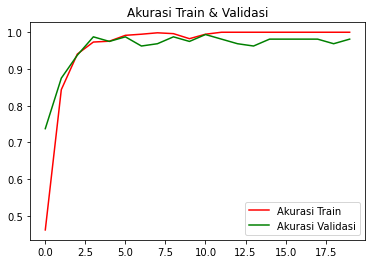

<Figure size 432x288 with 0 Axes>

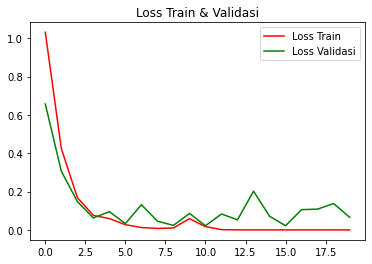

<Figure size 432x288 with 0 Axes>

In [16]:
#Plot Akurasi dan Loss

#Mengambil Nilai Akurasi, Jumlah Epoch, & Loss
akurasi = hist.history['accuracy']
loss = hist.history['loss']
n_epoch = range(len(akurasi))
val_akurasi = hist.history['val_accuracy']
val_loss = hist.history['val_loss']

#Plot Akurasi
plt.plot(n_epoch, akurasi, 'r', label='Akurasi Train')
plt.plot(n_epoch, val_akurasi, 'g', label='Akurasi Validasi')
plt.title('Akurasi Train & Validasi')
plt.legend(loc=0)
plt.figure()
plt.show()

print(' ')

# Plot Loss
plt.plot(n_epoch, loss, 'r', label='Loss Train')
plt.plot(n_epoch, val_loss, 'g', label='Loss Validasi')
plt.title('Loss Train & Validasi')
plt.legend(loc=0)
plt.figure()
plt.show()

# **Model Testing (Upload Image)**

Saving 00nKV8oHuTGi20gq.png to 00nKV8oHuTGi20gq.png
00nKV8oHuTGi20gq.png
Rock (Batu)


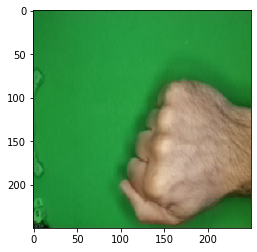

In [17]:
#Files Upload
uploaded = files.upload()

#Image Prediction
for fn in uploaded.keys():
  path = fn
  img = load_img(path, target_size=(250,250))
  imgplot = plt.imshow(img)
  x = img_to_array(img)
  x = np.expand_dims(x, axis=0)
 
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  
  print(fn)
  if classes[0][0]==1:
    print('Paper (Kertas)')
  elif classes[0][1]==1:
    print('Rock (Batu)')
  elif classes[0][2]==1:
    print('Scissor (Gunting)')
  else:
    print('Undetected (Tidak Terdeteksi)')

Model Memprediksi Dengan Benar